In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
from skimage.feature import blob_log
from tqdm import tqdm
from scipy.spatial import distance,
from scipy.interpolate import interp2d
from scipy import ndimage
import random as rd
%matplotlib inline

# load data

<Diffraction2D, title: , dimensions: (400, 400|144, 144)>


<IPython.core.display.Javascript object>


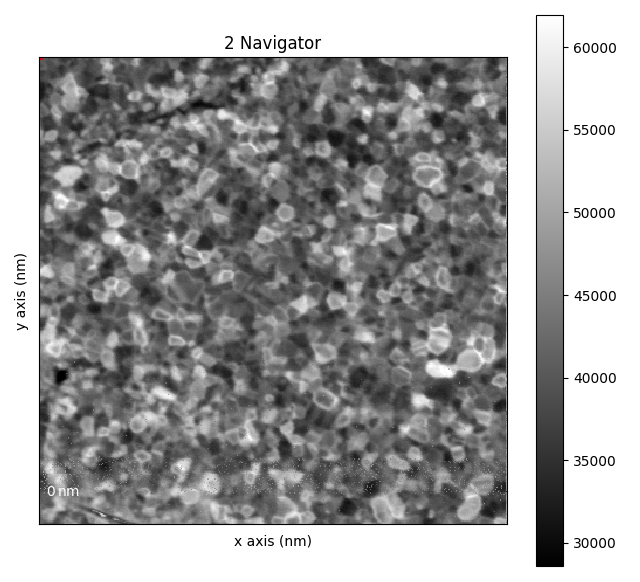

<IPython.core.display.Javascript object>


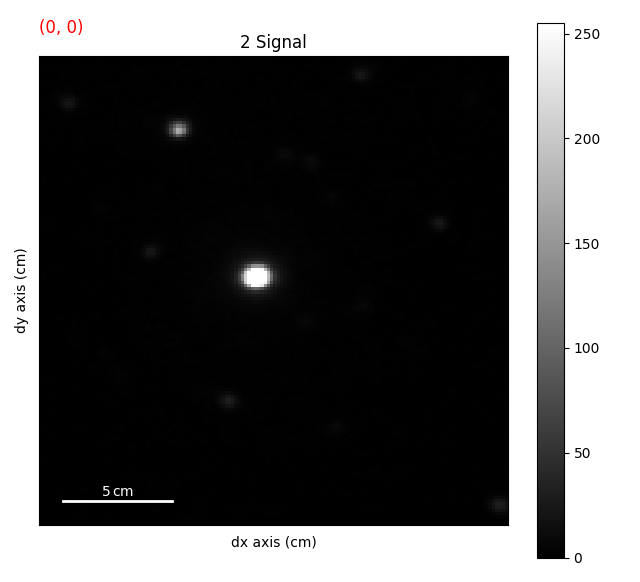

In [3]:
num_of_dataset = 2
file_path = "data/1.blo"
data_file = hs.load(file_path, lazy=False)
print(data_file)

data_file.plot(scalebar=True)

<IPython.core.display.Javascript object>


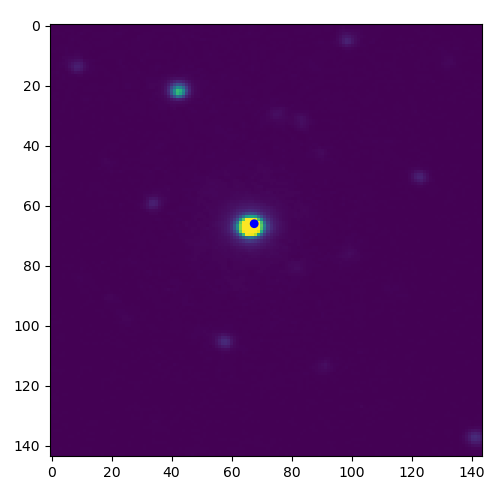

[4.5 6. ] 67.5 66.0


array([4.5, 6. ])

In [15]:
############################################################################ find center beam for first pattern
position = data_file.inav[0:1,0:1].get_direct_beam_position(method="interpolate",
        sigma=10,
        upsample_factor=2,
        kind="linear",
        )

img = np.array(data_file.inav[0,0].data)
img_size_x, img_size_y = img.shape

fig, axes = plt.subplots(figsize=(5,5))
axes.imshow(data_file.inav[0,0].data)
x, y = np.array([int(img_size_x/2),int(img_size_y/2)]) - position.data.flatten()
print(position.data.flatten(), x, y)
c = plt.Circle((x, y), 1, color='b', linewidth=2, fill=True)
axes.add_patch(c)
plt.tight_layout()
plt.show()
############################################################################
position.data.flatten()

# align diff patterns

<IPython.core.display.Javascript object>


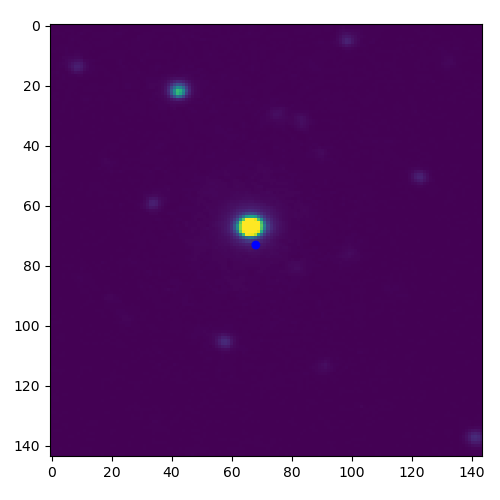


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

[4.5 6. ] [68.04479220137785, 73.10623231057626]



100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.43it/s]


<IPython.core.display.Javascript object>


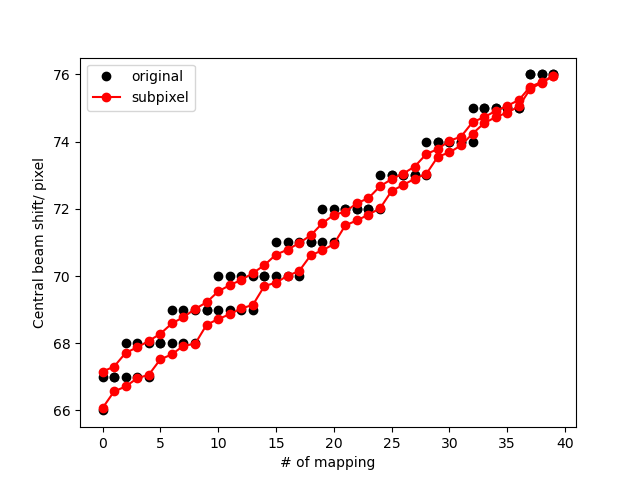

<IPython.core.display.Javascript object>


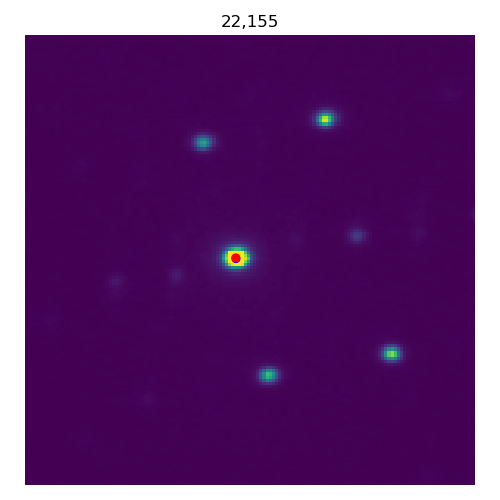

<IPython.core.display.Javascript object>


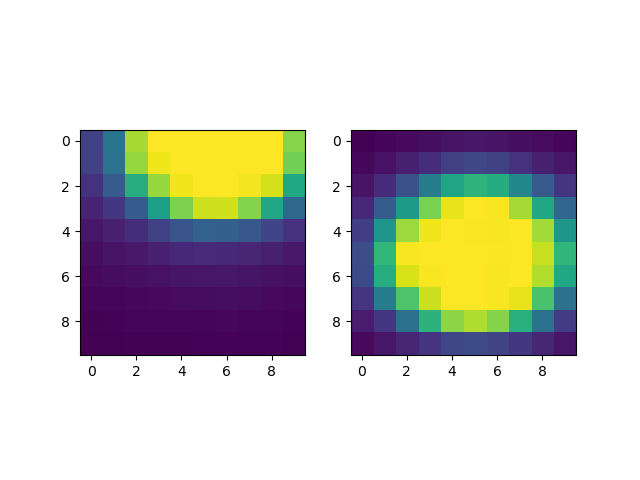

In [22]:
dim_x, dim_y = data_file.data.shape[:2]

img = np.array(data_file.inav[0,0].data)
img_size_x, img_size_y = img.shape

############################################################################ find center beam for first pattern
position = data_file.inav[0:1,0:1].get_direct_beam_position(method="interpolate",
        sigma=10,
        upsample_factor=2,
        kind="linear",
        )
fig, axes = plt.subplots(figsize=(5,5))
axes.imshow(data_file.inav[0,0].data)
x_center, y_center = np.array([int(img_size_x/2),int(img_size_y/2)]) - position.data.flatten()
print(position.data.flatten(), [x, y])
c = plt.Circle((x, y), 1, color='b', linewidth=2, fill=True)
axes.add_patch(c)
plt.tight_layout()
plt.show()
############################################################################
# x_center, y_center = [int(img_size_x/2),int(img_size_y/2)]
crop_x = [int(x_center-15), int(x_center+15)]
crop_y = [int(y_center-15), int(y_center+15)]

offset_center = []
for i in tqdm(range(0,dim_x,10)):
    offset_row = []
    if i!=0:
        x_center, y_center = offset_center[-1][0]
        
    for j in range(0,dim_y,10):
        crop_x = [int(x_center-15), int(x_center+15)]
        crop_y = [int(y_center-15), int(y_center+15)]
        img = np.array(data_file.inav[i,j].data)
        img_cropped = img[crop_x[0]:crop_x[1],crop_y[0]:crop_y[1]]
        blobs_log = blob_log(img_cropped,min_sigma=5, max_sigma=20, threshold=.05, overlap=0)
        if(len(blobs_log)>1):
#             print("more than one center beam detected, location = ",i, j, ", take the one closest to previous one as center")
            dist = []
            for k in blobs_log:
                x, y = k[0] + crop_x[0], k[1] + crop_y[0]
                dist.append(distance.euclidean([x, y], [x_center, y_center]))
            blob_x, blob_y = blobs_log[np.array(dist).argmin()][:2]
#             print(x_center, y_center)
            x_center, y_center = blob_x + crop_x[0], blob_y + crop_y[0]
#             print(x_center, y_center)
            
        elif (len(blobs_log)<1):
#             print("No center beam detected, location = ",i, j, ", take previous one as center"); 
            pass
        else: 
            x_center, y_center = blobs_log[0][0] + crop_x[0], blobs_log[0][1] + crop_y[0]
        offset_row.append([x_center, y_center])
    offset_center.append(offset_row)
    
# print(offset_center)    

############################################ subpixel refinement to [offset_center_subpixel]
offset_center_subpixel = []
for i in tqdm(range(0,dim_x,10)):
    offset_center_subpixel_row = []
    for j in range(0,dim_y,10):
        x, y = offset_center[i//10][j//10][0], offset_center[i//10][j//10][1]

        img = np.array(data_file.inav[i,j].data)
        img_cropped = img[int(x-5):int(x+5),int(y-5):int(y+5)]
        x_refine, y_refine = ndimage.measurements.center_of_mass(img_cropped)
        offset_center_subpixel_row.append([x_refine+x-5, y_refine+y-5])
    offset_center_subpixel.append(offset_center_subpixel_row)
# print(offset_center_subpixel)

############################################ plot central beam distribution on diagonal of dataset
plt.figure()
plt.plot(np.diagonal(offset_center)[0],'o',c='k',label='original')
plt.plot(np.diagonal(offset_center)[1],'o',c='k')
plt.plot(np.diagonal(offset_center_subpixel)[0],'-o',c='r')
plt.plot(np.diagonal(offset_center_subpixel)[1],'-o',c='r',label='subpixel')
plt.xlabel('# of mapping')
plt.ylabel('Central beam shift/ pixel')
plt.legend()

############################################ interpolate offset_center_subpixel to size of mapping, save in [peak_center_matrix]
x = range(0,dim_x,10)
y = range(0,dim_y,10)
f0 = interp2d(x, y, np.array(offset_center_subpixel)[:,:,0], kind='linear')
f1 = interp2d(x, y, np.array(offset_center_subpixel)[:,:,1], kind='linear')

peak_center_matrix = []
xnew = range(0,dim_x)
ynew = range(0,dim_y)
znew0 = f0(xnew, ynew)
znew1 = f1(xnew, ynew)
for i, j in zip(znew0, znew1):
    peak_center = []
    for k, l in zip(i, j):
        peak_center.append([k, l])
    peak_center_matrix.append(peak_center)
    
    
####################################### plot refined and unrefined center for a random diff pattern
i, j = rd.randrange(0, 300, 1), rd.randrange(0, 300, 1)
img = np.array(data_file.inav[i,j].data)
fig, axes = plt.subplots(figsize=(5,5))
axes.imshow(img)
y, x = np.array(offset_center)[i//10,j//10]
c = plt.Circle((x, y), 1, color='b', linewidth=2, fill=True)
axes.add_patch(c)
y, x = np.array(peak_center_matrix)[i,j]
c = plt.Circle((x, y), 1, color='r', linewidth=2, fill=True)
axes.add_patch(c)
axes.set_axis_off()
plt.title(str(i)+','+str(j))
plt.tight_layout()
plt.show()


###############################shift diff image (i ,j) to center, then crop to 120x120
shift_matrix = np.array([int(img_size_x/2),int(img_size_y/2)]) - np.array(peak_center_matrix)

i, j = 280, 0
img = np.array(data_file.inav[i,j].data)
shifted_image = ndimage.shift(img, shift_matrix[i, j])[int(img_size_x/2)-60:int(img_size_x/2)+60,int(img_size_y/2)-60:int(img_size_y/2)+60]
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img[int(img_size_x/2)-5:int(img_size_x/2)+5,int(img_size_y/2)-5:int(img_size_y/2)+5])
plt.subplot(1,2,2)
plt.imshow(shifted_image[55:65,55:65])

In [ ]:
# save the aligned data

aligned = np.zeros([data_file.data.shape[0],data_file.data.shape[1],120,120])
for i in tqdm(range(data_file.data.shape[0])):
    for j in range(data_file.data.shape[1]):
        img = np.array(data_file.inav[i,j].data)
        aligned[i,j,:,:] = ndimage.shift(img, shift_matrix[i, j])[int(img_size_x/2)-60:int(img_size_x/2)+60,int(img_size_y/2)-60:int(img_size_y/2)+60]
aligned = hs.signals.Signal2D(aligned)
aligned.save("data/1_aligned.blo")